#1. Introduction

In [ ]:
#import library

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
#Menghubungkan drive dengan google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import Dataset 
df = pd.read_csv('/content/drive/MyDrive/Ruangguru/Final project/Data LEFT UDAH BENER.csv')
user = pd.read_csv("users.csv")[['id','age','gender','state','city','country','traffic_source']]
order = pd.read_csv("orders.csv")[['order_id','user_id','num_of_item']]

#Process Dataset
col = ['order_id','status','created_at','cost','sale_price']
data = df[df['status'].isin(['Complete','Cancelled'])][col].drop_duplicates()
data = data[col]

data = data \
      .groupby(['order_id','status','created_at']) \
      .agg({'cost':'sum', 'sale_price':'sum'}) \
      .reset_index() \
      .drop_duplicates(['order_id','status'])

#Join Dataset
data = data \
        .merge(order, how='inner', left_on='order_id', right_on='order_id') \
        .merge(user, how='inner', left_on='user_id', right_on='id') \
        .drop(['user_id','id'], axis=1)

#data.to_csv('order_status_dataset.csv', index=False)

In [ ]:
#Import Dataset 
df = pd.read_csv('/content/drive/MyDrive/Ruangguru/Final project/order_status_dataset.csv')

In [ ]:
df.head(3)

,order_id,status,created_at,cost,sale_price,num_of_item,age,gender,state,city,country,traffic_source
0,1,Complete,2019-07-19,28.294341,49.990002,4,30,M,Gyeonggi-do,Namyangju City,South Korea,Search
1,4,Cancelled,2020-02-10,40.023121,77.040001,2,30,M,Gyeonggi-do,Namyangju City,South Korea,Search
2,5,Cancelled,2021-09-07,7.076460,19.990000,1,48,M,Jiangsu,Guangzhou,China,Search


** Insight **
- Pada data "left udah bener" terdapat data yang duplikat dan tiap row belum mewakili satu user maka dilakukan pemprosesan dataset


#2. Data Understanding

In [ ]:
#Menampilkan informasi terkait data colomn
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49787 entries, 0 to 49786
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        49787 non-null  int64  
 1   status          49787 non-null  object 
 2   created_at      49787 non-null  object 
 3   cost            49787 non-null  float64
 4   sale_price      49787 non-null  float64
 5   num_of_item     49787 non-null  int64  
 6   age             49787 non-null  int64  
 7   gender          49787 non-null  object 
 8   state           49787 non-null  object 
 9   city            49267 non-null  object 
 10  country         49787 non-null  object 
 11  traffic_source  49787 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.6+ MB


In [ ]:
#Menampilkan jumlah baris dan kolom dalam dataset
df.shape

(49787, 12)

In [ ]:
#Menampilkan seluruh nama kolom
df.columns.values

array(['order_id', 'status', 'created_at', 'cost', 'sale_price',
       'num_of_item', 'age', 'gender', 'state', 'city', 'country',
       'traffic_source'], dtype=object)

In [ ]:
#Melihat apakah ada missing value dari dataset
df.isna().sum()

order_id            0
status              0
created_at          0
cost                0
sale_price          0
num_of_item         0
age                 0
gender              0
state               0
city              520
country             0
traffic_source      0
dtype: int64

**Insight**

*    terdapat 12 fitur yang merupakan gabungan dari dataset sales, users, order, product
*   Terdapat 49787 baris dengan 12 kolom data
*   kolom yang memiliki missing value adalah city



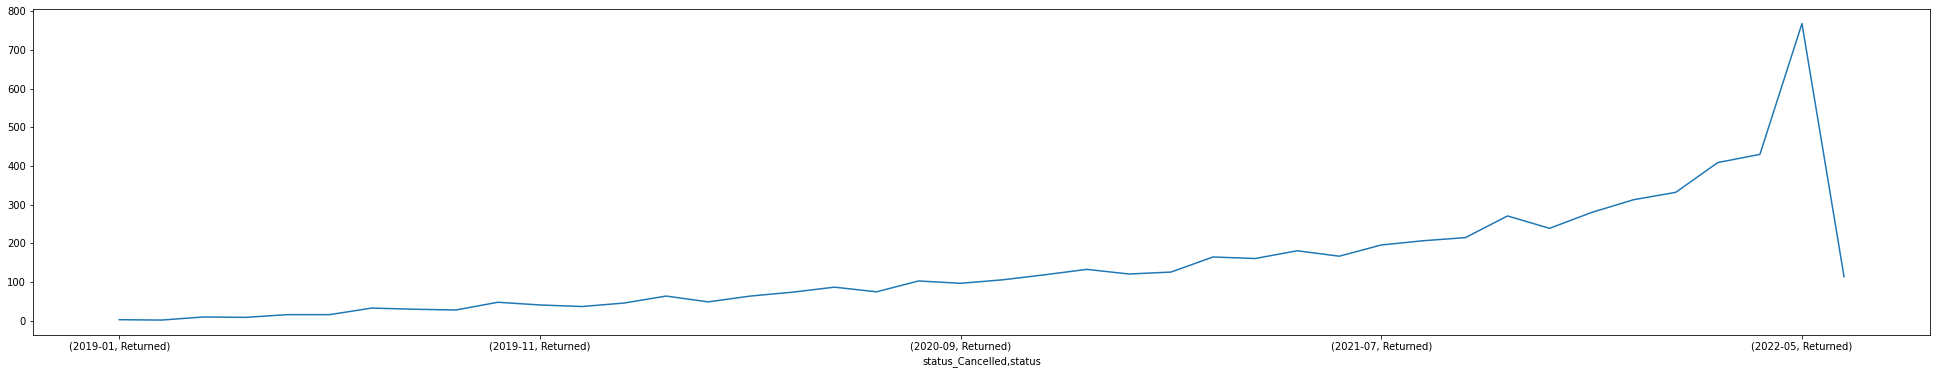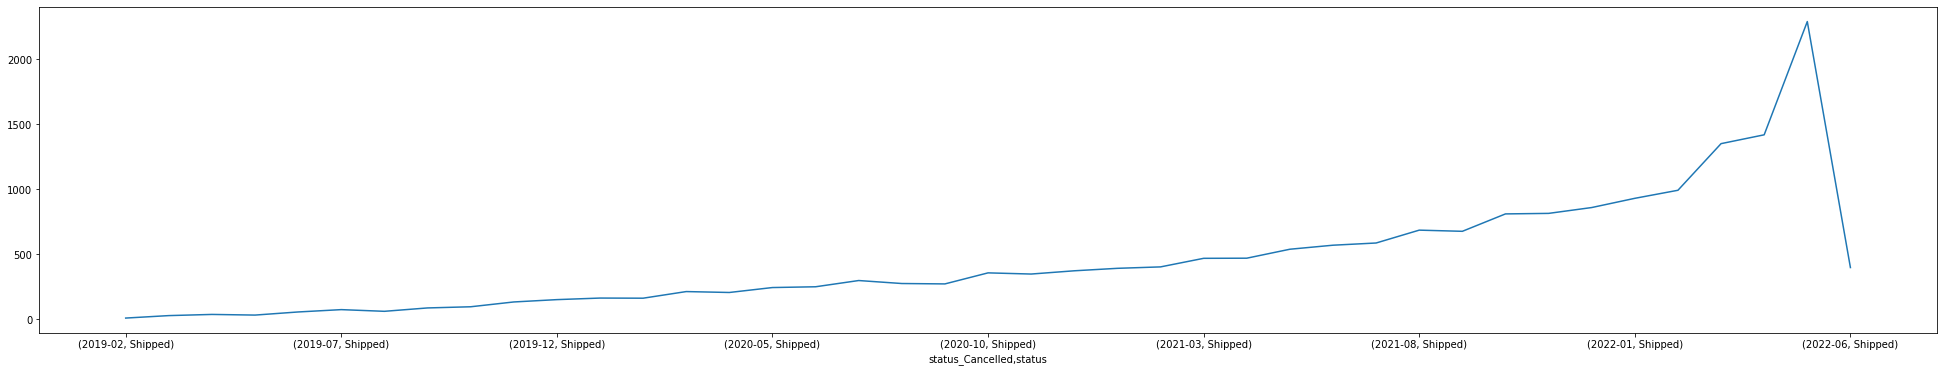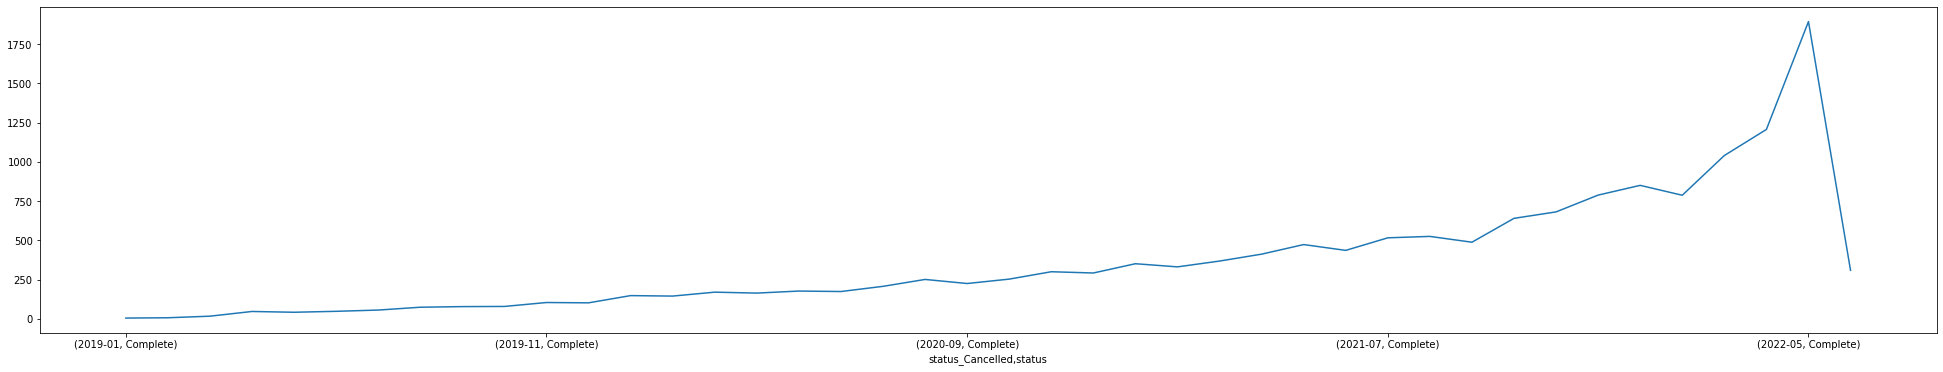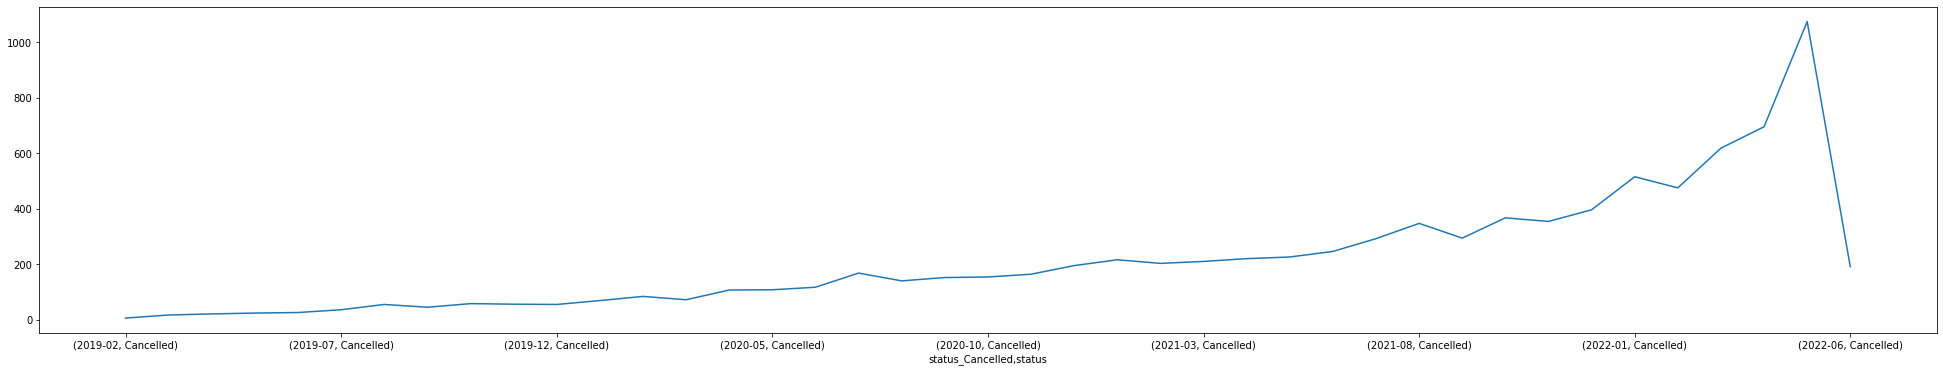

- selalu ada cancel product tiap tahunnya

In [ ]:
# Melihat data unique dari setiap fitur dalam tabel
for feature in df.columns:
    print(
        f"- jumlah nilai unique pada kolom `{feature}`:",
        df[feature].nunique()
    )

- jumlah nilai unique pada kolom `order_id`: 49787
- jumlah nilai unique pada kolom `status`: 2
- jumlah nilai unique pada kolom `created_at`: 1216
- jumlah nilai unique pada kolom `cost`: 24809
- jumlah nilai unique pada kolom `sale_price`: 6038
- jumlah nilai unique pada kolom `num_of_item`: 4
- jumlah nilai unique pada kolom `age`: 59
- jumlah nilai unique pada kolom `gender`: 2
- jumlah nilai unique pada kolom `state`: 224
- jumlah nilai unique pada kolom `city`: 6396
- jumlah nilai unique pada kolom `country`: 15
- jumlah nilai unique pada kolom `traffic_source`: 5


In [ ]:
#mengecek baris yang duplikat
df[df['order_id'].duplicated()]

,order_id,status,created_at,cost,sale_price,num_of_item,age,gender,state,city,country,traffic_source


**Insight** 

*  Setiap kolom mempunyai nilai unik, nilai unik yang paling sedikit adalah gender dan yang paling banyak adalah id karena id merupakan primary key
*   Tidak ada data yang duplikat



# 3. Exploratory Data Analysis

In [ ]:
#melihat type kolom pada setiap dataset
df.dtypes

order_id            int64
status             object
created_at         object
cost              float64
sale_price        float64
num_of_item         int64
age                 int64
gender             object
state              object
city               object
country            object
traffic_source     object
dtype: object

In [ ]:
#visualisasi kolom status untuk melihat jumlah data
def plot_count(data, x=None, y=None, palette=None, figsize=(12, 3), **kwargs):
    column_order = data[x or y].value_counts().index

    plt.figure(figsize=figsize)
    sns.countplot(
        x=x, y=y, data=data, order=column_order,
        palette=palette, **kwargs
    )
    plt.grid(False)

MAIN_COLOR = ["#29B5BF"] 
OTHER_COLOR = ["#777777"]

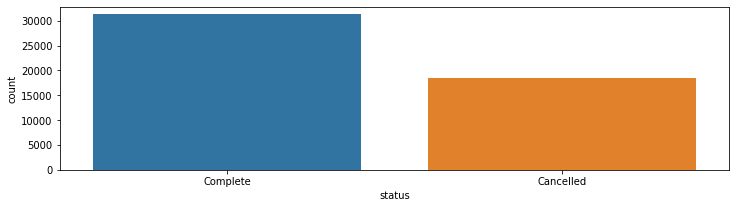

In [ ]:
plot_count(x="status", data=df)

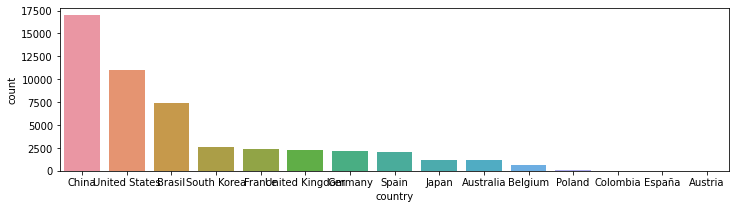

In [ ]:
plot_count(x="country", data=df)

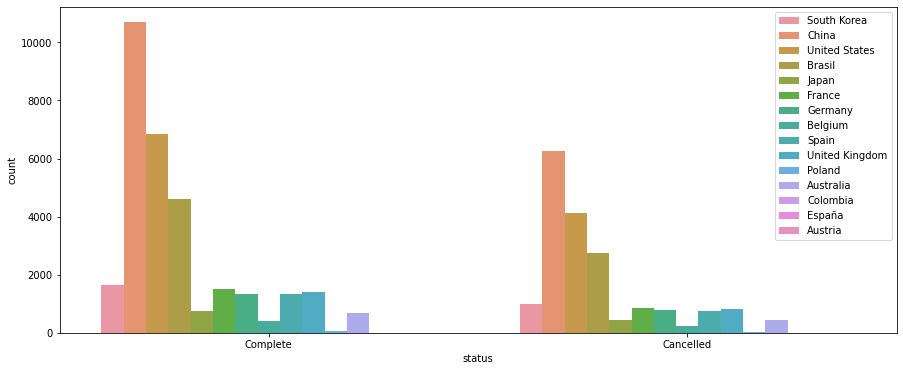

In [ ]:
plot_count(x="status", hue="country",data=df, figsize=(15, 6))
plt.legend(loc="upper right")
plt.show()

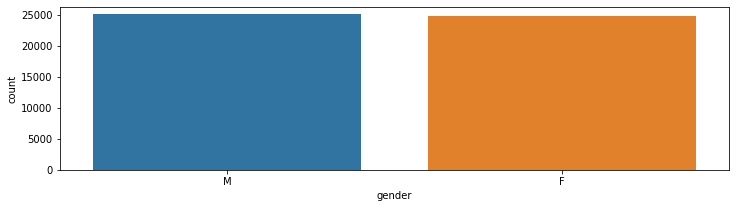

In [ ]:
plot_count(x="gender", data=df)

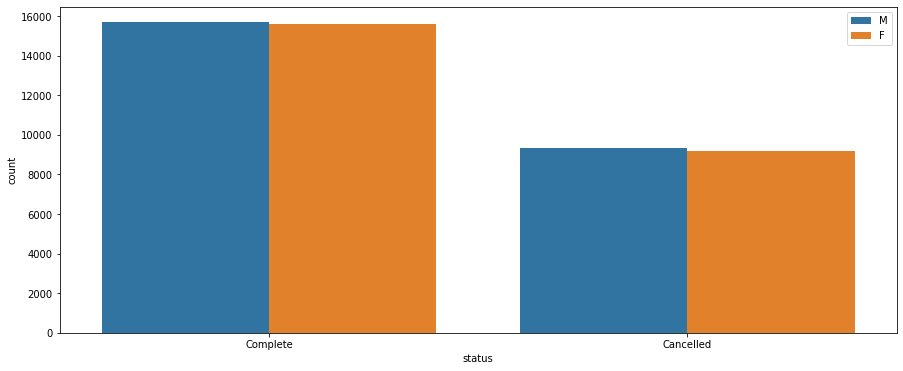

In [ ]:
plot_count(x="status", hue="gender",data=df, figsize=(15, 6))
plt.legend(loc="upper right")
plt.show()

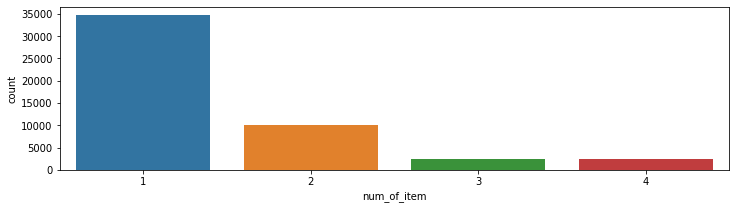

In [ ]:
plot_count(x="num_of_item", data=df)

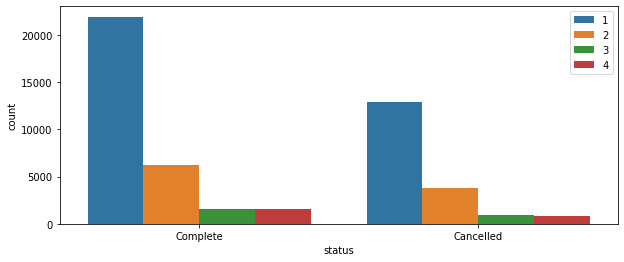

In [ ]:
plot_count(x="status", hue="num_of_item",data=df, figsize=(10, 4))
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Menampilkan deskripsi data
df.describe()

,order_id,cost,sale_price,num_of_item,age
count,49787.000000,49787.000000,49787.000000,49787.000000,49787.000000
mean,62364.480186,30.865498,64.262905,1.447446,40.977484
std,35952.433711,32.296063,69.191553,0.799148,16.998053
min,1.000000,0.008300,0.020000,1.000000,12.000000
25%,31339.000000,11.877395,25.000000,1.000000,26.000000
50%,62353.000000,21.128000,42.990002,1.000000,41.000000
75%,93529.500000,37.769000,78.000000,2.000000,56.000000
max,124507.000000,557.151002,1036.000000,4.000000,70.000000


# 4. Cleaning data

## 4.1 Membuat label 1 dan 0 untuk product yang di cancel

In [ ]:
#baris yang kosong dilabeli dengan 0 dan yang tidak kosong dilabeli dengan 1
df["status"] = df["status"].replace('Cancelled', 1)
df["status"] = df["status"].replace('Complete', 0)

In [ ]:
df.head()

,order_id,status,created_at,cost,sale_price,num_of_item,age,gender,state,city,country,traffic_source
0,1,0,2019-07-19,28.294341,49.990002,4,30,M,Gyeonggi-do,Namyangju City,South Korea,Search
1,4,1,2020-02-10,40.023121,77.040001,2,30,M,Gyeonggi-do,Namyangju City,South Korea,Search
2,5,1,2021-09-07,7.076460,19.990000,1,48,M,Jiangsu,Guangzhou,China,Search
3,7,1,2021-11-08,66.102079,141.789997,2,16,M,Jilin,Shenzhen,China,Search
4,8,0,2022-05-15,32.055419,69.989998,4,14,M,Jiangsu,Harbin,China,Search


## 4.3 Merapihkan data kolom

In [ ]:
#melihat nilai unik pada setiap kolom
for feature in df.columns:
    print(
        f"- jumlah nilai unique pada kolom `{feature}`:",
        df[feature].nunique()
    )

- jumlah nilai unique pada kolom `order_id`: 49787
- jumlah nilai unique pada kolom `status`: 2
- jumlah nilai unique pada kolom `created_at`: 1216
- jumlah nilai unique pada kolom `cost`: 24809
- jumlah nilai unique pada kolom `sale_price`: 6038
- jumlah nilai unique pada kolom `num_of_item`: 4
- jumlah nilai unique pada kolom `age`: 59
- jumlah nilai unique pada kolom `gender`: 2
- jumlah nilai unique pada kolom `state`: 224
- jumlah nilai unique pada kolom `city`: 6396
- jumlah nilai unique pada kolom `country`: 15
- jumlah nilai unique pada kolom `traffic_source`: 5


In [ ]:
#Merubah isi dari kolom country
df["country"] = df["country"].replace('Austria', 'other')
df["country"] = df["country"].replace('España', 'other')
df["country"] = df["country"].replace('Colombia', 'other')
df["country"] = df["country"].replace('Poland', 'other')
df["country"] = df["country"].replace('Belgium', 'other')

In [ ]:
#merubah isi kolom gender dengan 1, 0
df["gender"] = df["gender"].replace('M', 1)
df["gender"] = df["gender"].replace('F', 0)

In [ ]:
#menghapus kolom yang tidak terpakai
df = df.drop(columns=['order_id', 'city', 'state'])

In [ ]:
df.head()

,status,created_at,cost,sale_price,num_of_item,age,gender,country,traffic_source
0,0,2019-07-19,28.294341,49.990002,4,30,1,South Korea,Search
1,1,2020-02-10,40.023121,77.040001,2,30,1,South Korea,Search
2,1,2021-09-07,7.076460,19.990000,1,48,1,China,Search
3,1,2021-11-08,66.102079,141.789997,2,16,1,China,Search
4,0,2022-05-15,32.055419,69.989998,4,14,1,China,Search


## 4.4 Korelasi dan outliers


In [ ]:
# Menampilkan korelasi antar variabel
df.corr()

,status,cost,sale_price,num_of_item,age,gender
status,1.000000,0.001518,0.001661,-0.001186,0.004520,0.001395
cost,0.001518,1.000000,0.982715,0.105121,-0.001863,0.063825
sale_price,0.001661,0.982715,1.000000,0.103198,-0.000293,0.060713
num_of_item,-0.001186,0.105121,0.103198,1.000000,-0.002068,0.006822
age,0.004520,-0.001863,-0.000293,-0.002068,1.000000,0.000657
gender,0.001395,0.063825,0.060713,0.006822,0.000657,1.000000


In [ ]:
#Faktorize dataframe
for column in df.columns:
     df[column] = pd.factorize(df[column])[0]

In [ ]:
#korelasi tiap kolom pada dataframe
df.corr()

,status,created_at,cost,sale_price,num_of_item,age,gender,country,traffic_source
status,1.000000,-0.000398,0.004071,0.001006,-0.003533,0.000019,-0.001395,0.000701,-0.001075
created_at,-0.000398,1.000000,0.025188,0.006308,0.005712,-0.007314,0.005592,-0.000848,0.006136
cost,0.004071,0.025188,1.000000,0.341604,-0.055636,0.003969,0.056922,-0.003205,-0.003698
sale_price,0.001006,0.006308,0.341604,1.000000,-0.122272,0.001852,0.019990,-0.001266,0.002722
num_of_item,-0.003533,0.005712,-0.055636,-0.122272,1.000000,-0.002433,0.003622,0.002170,0.003881
age,0.000019,-0.007314,0.003969,0.001852,-0.002433,1.000000,0.000097,-0.003950,-0.000999
gender,-0.001395,0.005592,0.056922,0.019990,0.003622,0.000097,1.000000,0.001653,-0.004218
country,0.000701,-0.000848,-0.003205,-0.001266,0.002170,-0.003950,0.001653,1.000000,0.001234
traffic_source,-0.001075,0.006136,-0.003698,0.002722,0.003881,-0.000999,-0.004218,0.001234,1.000000


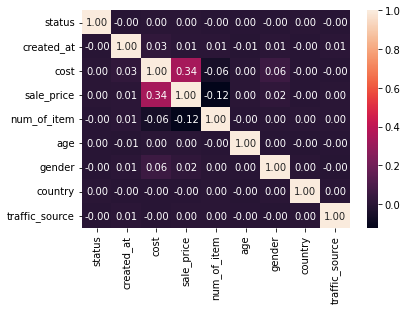

In [ ]:
# Visualisasikan correlation coefficient di atas dengan bantuan heat map
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

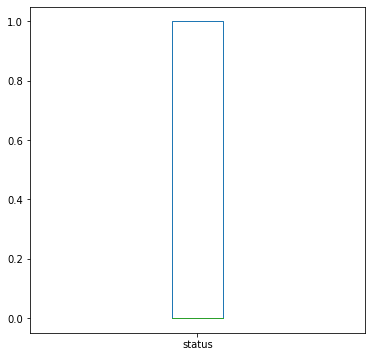

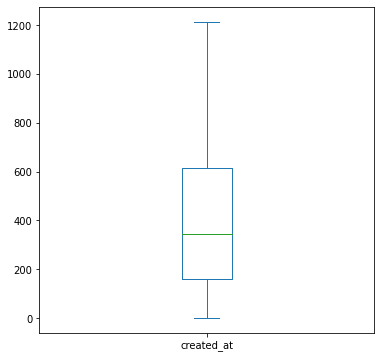

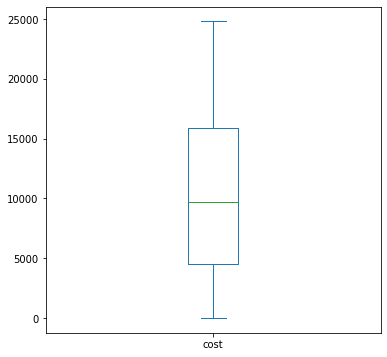

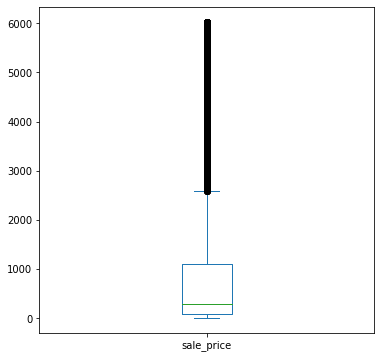

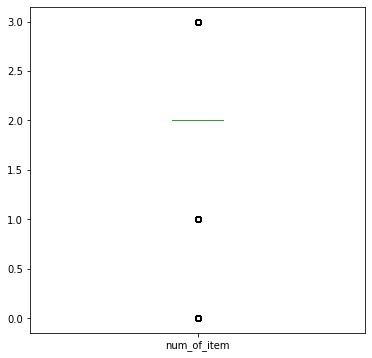

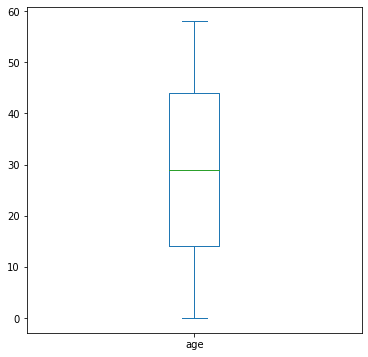

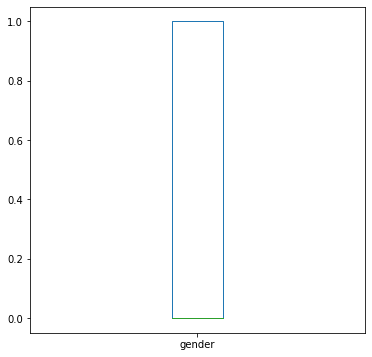

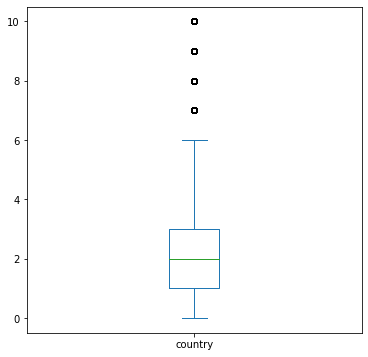

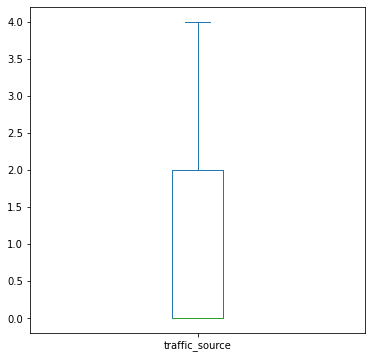

In [ ]:
# Visualisasikan fitur-fitur numerik ke Boxplot untuk melihat bagaimana data tersebar
for feature in df.columns:
  df[feature].plot(kind="box", figsize=(6, 6))
  plt.grid(False)
  plt.show()

In [ ]:
#melihat deskripsi pada dataframe
df.describe()

,status,created_at,cost,sale_price,num_of_item,age,gender,country,traffic_source
count,49787.000000,49787.000000,49787.000000,49787.000000,49787.000000,49787.000000,49787.00000,49787.000000,49787.000000
mean,0.371944,405.212646,10492.287665,903.451363,1.752224,28.868399,0.49772,2.882680,0.690361
std,0.483329,291.905146,6852.293248,1315.353807,0.619736,17.046088,0.50000,2.580211,1.163376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,162.000000,4531.000000,92.000000,2.000000,14.000000,0.00000,1.000000,0.000000
50%,0.000000,343.000000,9730.000000,283.000000,2.000000,29.000000,0.00000,2.000000,0.000000
75%,1.000000,614.000000,15909.500000,1093.000000,2.000000,44.000000,1.00000,3.000000,2.000000
max,1.000000,1215.000000,24808.000000,6037.000000,3.000000,58.000000,1.00000,10.000000,4.000000


In [ ]:
#menghitung IQR, Lower Whisker dan upper whisker
Q1=df['country'].quantile(0.25)
Q3=df['country'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

1.0
3.0
2.0
-2.0 6.0


In [ ]:
#mengubah nilai pencilan
df = df[df['country'] < Upper_Whisker]

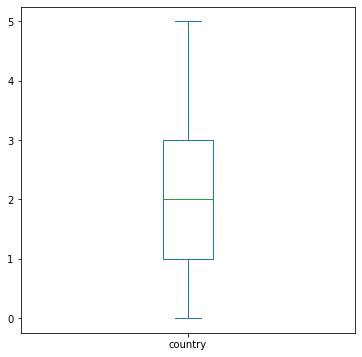

In [ ]:
#visualisasi outlier di kolom country
df['country'].plot(kind="box", figsize=(6, 6))
plt.grid(False)
plt.show()

In [ ]:
#menghitung IQR, Lower Whisker dan upper whisker
Q1=df['num_of_item'].quantile(0.25)
Q3=df['num_of_item'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

1.0
2.0
1.0
-0.5 3.5


In [ ]:
#mengubah nilai pencilan
df = df[df['num_of_item'] < Upper_Whisker]
df = df[df['num_of_item'] > Lower_Whisker]

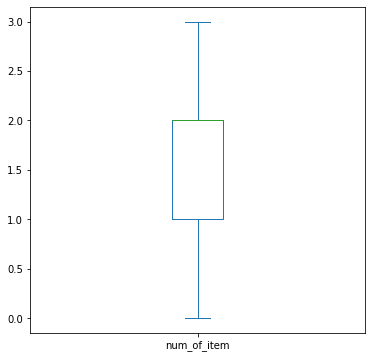

In [ ]:
#visualisasi outlier di kolom brand
df['num_of_item'].plot(kind="box", figsize=(6, 6))
plt.grid(False)
plt.show()

In [ ]:
#melakukan one hot encoder
encoder = OneHotEncoder()
encoder.fit(df.select_dtypes(include="object"))
X_onehot = pd.DataFrame(encoder.transform(df.select_dtypes(include="object")).toarray(),columns=encoder.get_feature_names_out())

X_preprocessed = pd.concat([df.select_dtypes(exclude="object"), X_onehot],axis=1)

scaler = StandardScaler()
scaler.fit(X_preprocessed)
X_scaled = pd.DataFrame(scaler.transform(X_preprocessed),columns=X_preprocessed.columns)

X_scaled.head()

,status,created_at,cost,sale_price,num_of_item,age,gender,country,traffic_source
0,-0.769878,-1.387356,-1.530144,-0.687054,-2.824706,-1.693698,-0.993296,-1.552147,-0.594005
1,1.298907,-1.383934,-1.529999,-0.686294,-1.211694,-1.693698,-0.993296,-1.552147,-0.594005
2,1.298907,-1.380513,-1.529853,-0.685535,0.401318,-1.635018,-0.993296,-0.721750,-0.594005
3,1.298907,-1.377091,-1.529707,-0.684776,-1.211694,-1.576338,-0.993296,-0.721750,-0.594005
4,-0.769878,-1.373670,-1.529561,-0.684016,-2.824706,-1.517658,-0.993296,-0.721750,-0.594005


# 5. Modelling

In [ ]:
#Membagi dataset menjadi data testing dan data training dengan perbandingan data 80% : 20%
X = df.drop(['status'], axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=25)

In [ ]:
#handle imbalance dataset
sm = SMOTE(sampling_strategy='auto')
X_r, y_r= sm.fit_resample(X_train, y_train)

print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_r))

Original dataset shape is  Counter({0: 20865, 1: 12318})
Resample dataset shape is  Counter({0: 20865, 1: 20865})


In [ ]:
#membuat model machine learning
pipeline  = []
pipeline.append(SVC())
pipeline.append(KNeighborsClassifier())
pipeline.append(DecisionTreeClassifier())

In [ ]:
# memasukkan model machine learning yang telah dibuat kedalam sebuah list
model_list = ['SVM', 'KNN', 'Decision']
acc_list = []
auc_list = []
cm_list = []
report = []

In [ ]:
for model in pipeline:
  model.fit(X_r, y_r)
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
  auc_list.append(round(metrics.auc(fpr,tpr), 2))
  cm_list.append(confusion_matrix(y_test, y_pred))

In [ ]:
#membuat dataframe terkait informasi model
result = pd.DataFrame({'Model' :model_list,
                       'Accuracy' : acc_list,
                       'AUC' : auc_list})

In [ ]:
#akurasi model
result

,Model,Accuracy,AUC
0,SVM,0.473481,0.50
1,KNN,0.513018,0.50
2,Decision,0.518322,0.51


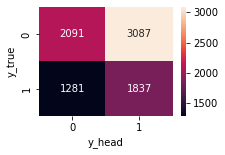

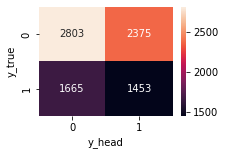

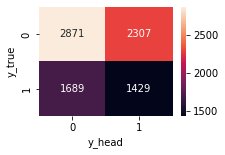

In [ ]:
#Visualisasi hasil klasifikasi
for model in cm_list:
  f, ax = plt.subplots(figsize=(3,2))
  sns.heatmap(model, annot=True, fmt=".0f", ax=ax)
  plt.xlabel("y_head")
  plt.ylabel("y_true")
  plt.show()

** Insight **
- dataset yang digunakan untuk pelatihan dan testing menggunakan perbandingan 80:20
- Pada modelling machine learining dilakukan handling imbalance dataset menggunakan SMOTE karena label dataset complete jumlahnya 2x lebih banyak daripada label dataset cancel
Algoritma yang dipakai adalah SVM, KNN dan decision tree
- Algoritma yang paling bagus akurasinya dalam mengklasifikasikan product cancel adalah decision tree